In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift
from scipy.stats import t
from numpy import sqrt, mean

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'
# file with psi = 0 
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')


In [3]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [4]:
Ux = np.array([0.17091544, 0.2196002 , 0.24884891, 0.22784447, 0.365201  ,
       0.37375478, 0.39257039, 0.37231073, 0.41550739, 0.43636989,
       0.45111672, 0.46662792, 0.48854647, 0.49640163, 0.51887196,
       0.52827061, 0.54437941, 0.54929705, 0.56552202, 0.57508514,
       0.58477563, 0.59755615])

Uy = np.array([ 2.98957309e-01,  9.64168660e-05, -1.46797090e-02, -9.75160307e-02,
       -5.19632419e-03, -4.59904496e-02, -2.32619177e-02, -3.68628550e-02,
       -2.17454902e-02, -2.99040715e-03, -9.57263434e-03, -1.21971856e-03,
       -5.82043301e-03, -1.21835241e-02,  2.33133879e-03, -6.70864695e-03,
       -7.49637624e-03, -9.90104750e-03, -5.72381167e-03, -5.34194980e-03,
       -6.43512919e-03, -4.68551265e-03])

wavenumbers = np.array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [5]:
def pedm(wavenumbers, uvals, p0=None, bounds=None, water_depth=np.inf):
    def pedm_fit_function(x, a, b, c):
        return a * x + b * np.exp(c * x)

    popt, pcov = curve_fit(pedm_fit_function, np.log(wavenumbers), uvals, p0=p0, bounds=bounds)

    eps_PEDM = np.sqrt(np.mean((pedm_fit_function(np.log(wavenumbers), *popt) - uvals)**2))
    eps_EDM = eps_EDM = np.sqrt(np.mean((np.polyval(popt, np.log(wavenumbers)) - uvals)**2))

    return popt, np.polyfit(np.log(wavenumbers), uvals, 1), eps_PEDM, eps_EDM, {"additional_info": "verbose_info"}

In [12]:
def find_current_depth_profile(wavenumbers, Ux, Uy, water_depth=np.inf):
    def U_Phill(Uw, z):
        alpha = 0.008
        g = 9.81
        return 2 * alpha * Uw * (np.exp(2 * g / Uw**2 * z) -
                                 np.sqrt(-2 * np.pi * g / Uw**2 * z) *
                                 np.erfc(np.sqrt(-2 * g / Uw**2 * z)))

    def pedm_fit_function(x, a, b, c):
        return a * x + b * np.exp(c * x)

    def linear_profile(x, a, b):
        return a * x + b

    def effective_depth_method(wavenumbers, uvals, water_depth):
        Z_eff_lin = -(2 * wavenumbers)**-1 * np.tanh(np.abs(water_depth) * wavenumbers)
        Z_eff_log = -(3.56 * wavenumbers)**-1

        Z_eff_Phillips = -np.pi * (8 * wavenumbers)**-1

        Z_eff = {"lin": Z_eff_lin, "log": Z_eff_log, "Phillips": Z_eff_Phillips}

        results = {}

        for i, profile_type in enumerate(["lin", "log", "Phillips"]):
            uvals_profile = Ux if i == 0 else Uy

            if profile_type == "Phillips" and water_depth == np.inf:
                continue

            if profile_type == "lin":
                popt, _ = curve_fit(linear_profile, Z_eff_lin, uvals_profile)
            else:
                popt, _ = curve_fit(pedm_fit_function, np.log(wavenumbers), uvals_profile)

            Z_eff_profile = Z_eff[profile_type]

            uTilde = linear_profile(Z_eff_lin, *popt) if profile_type == "lin" else pedm_fit_function(np.log(wavenumbers), *popt)

            eps = sqrt(mean((uTilde - uvals_profile)**2))

            U_fun = lambda z: linear_profile(z, *popt) if profile_type == "lin" else pedm_fit_function(np.log(z), *popt)

            results[profile_type] = {"Z_eff": Z_eff_profile, "U_fun": U_fun, "eps": eps}

        return results

    inds = ~np.isnan(Ux) & ~np.isnan(Uy)
    wavenumbers = wavenumbers[inds]

    U0 = np.mean(Ux[inds])
    V0 = np.mean(Uy[inds])
    phi = 0

    U1 = Ux[inds] * np.cos(-phi) - Uy[inds] * np.sin(-phi)
    U2 = Ux[inds] * np.sin(-phi) + Uy[inds] * np.cos(-phi)

    results = {"global": {"wavenumbers": wavenumbers,
                          "U1": U1,
                          "U2": U2,
                          "phi": phi,
                          "Ux": Ux[inds],
                          "Uy": Uy[inds]}}

    if water_depth == np.inf:
        water_depth = np.inf

    results["EDM"] = effective_depth_method(wavenumbers, U1, water_depth)
    results["PEDM"] = {}

    for i, uvals in enumerate([U1, U2]):
        # Provide bounds for the curve_fit function
        bounds = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
        pPEDM, pEDM, eps_PEDM, eps_EDM, verbose = pedm(wavenumbers, uvals, bounds=bounds, water_depth=water_depth)

        U_fun = lambda z: np.polyval(pPEDM, z) if i == 0 else np.polyval(pEDM, z)

        results["PEDM"][f"U{i+1}_fun"] = U_fun
        results["PEDM"][f"eps{i+1}"] = eps_PEDM
        results["PEDM"][f"verbose{i+1}"] = verbose

    return results

# Example usage:
results = find_current_depth_profile(wavenumbers, Ux, Uy, water_depth=np.inf)
results

{'global': {'wavenumbers': array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
         0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
         0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
         0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
         0.28758858, 0.30009243]),
  'U1': array([0.17091544, 0.2196002 , 0.24884891, 0.22784447, 0.365201  ,
         0.37375478, 0.39257039, 0.37231073, 0.41550739, 0.43636989,
         0.45111672, 0.46662792, 0.48854647, 0.49640163, 0.51887196,
         0.52827061, 0.54437941, 0.54929705, 0.56552202, 0.57508514,
         0.58477563, 0.59755615]),
  'U2': array([ 2.98957309e-01,  9.64168660e-05, -1.46797090e-02, -9.75160307e-02,
         -5.19632419e-03, -4.59904496e-02, -2.32619177e-02, -3.68628550e-02,
         -2.17454902e-02, -2.99040715e-03, -9.57263434e-03, -1.21971856e-03,
         -5.82043301e-03, -1.21835241e-02,  2.33133879e-03, -6.70864695e-03,
         -7.49637624e-03, -9.9010

Text(0, 0.5, 'Depth [m]')

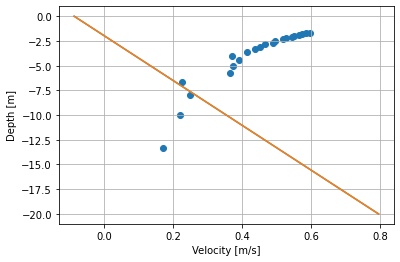

In [13]:
plt.plot(results['PEDM']['U1_fun'](z), z)

plt.plot(results['PEDM']['U2_fun'](z), z)

plt.scatter(Ux, -1/(2*wavenumbers))

plt.grid(True)
plt.xlabel("Velocity [m/s]")
plt.ylabel("Depth [m]")

In [14]:
results['PEDM']['U1_fun']

<function __main__.find_current_depth_profile.<locals>.<lambda>(z)>

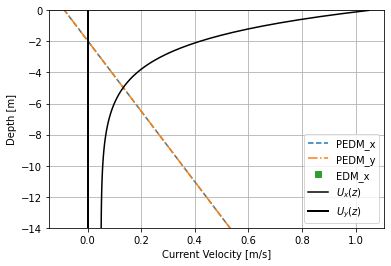

In [15]:
# Plotting dashed line
plt.plot(results['PEDM']['U1_fun'](z), z, '--', label='PEDM_x')

# Plotting dash-dot line
plt.plot(results['PEDM']['U2_fun'](z), z, '-.', label='PEDM_y')

# Plotting square markers
plt.plot(Ux, 1/(2*wavenumbers), 's', label='EDM_x')

# Plotting black line
plt.plot(U*np.cos(np.radians(0)), z, 'k', label=r'$U_{x}(z)$')

# Plotting black dash-dot line
plt.plot(-U*np.sin(np.radians(0)), z, 'k', label=r'$U_{y}(z)$', linewidth=2)

plt.legend()
plt.grid(True)
plt.xlabel("Current Velocity [m/s]")
plt.ylabel("Depth [m]")
plt.ylim(-14,0)
plt.show()